In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import random
from torchvision.utils import save_image
import os
from torch.optim.lr_scheduler import StepLR
import glob
import cv2
import math

from torch.utils.data import Subset

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UNET_PATH = 'model_weight/unet.pth'
DNN_PATH = 'model_weight/dnn.pth'

In [3]:
# Hyperparameters
BATCH_SIZE = 256
num_epochs = 12
dnn_epoch = 50
learning_rate  = 1e-5
MNIST = True
CIFAR10 = False

# Network Training Settings
Train_BASE_DNN = True
Train_Unet = True

if (os.path.exists(DNN_PATH)) == True:
    Train_BASE_DNN = False

if (os.path.exists(UNET_PATH)) == True:
    Train_Unet = False

In [4]:
if (os.path.exists("./output")) == False:
    os.mkdir("output")

if (os.path.exists("./model_weight")) == False:
    os.mkdir("model_weight")

if (os.path.exists("./test_out")) == False:
    os.mkdir("test_out")

for epoch in range (num_epochs):
    if (os.path.exists("./output/%03d" % epoch)) == False:
        os.mkdir("./output/%03d" % epoch)
    else:
        files = glob.glob("./output/%03d/*.png" % epoch)

        for f in files:
          os.remove(f)

In [5]:
train_dataset = datasets.MNIST('data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_dataset =  datasets.MNIST('data', train=False, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor()
                       ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# DNN

In [6]:
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


dnn_criterion = nn.CrossEntropyLoss()


def dnn_test(dnn_model, test_loader):
    total = 0
    total_correct = 0

    test_loss = 0

    for i, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()

        outputs = dnn_model(images)
        loss = dnn_criterion(outputs, labels)

        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += BATCH_SIZE

        test_loss += loss.item()

    test_loss /= len(test_loader)

    return total_correct / total, test_loss

In [7]:
if (Train_BASE_DNN):
    dnn_model = VGG11().cuda()
    dnn_criterion = nn.CrossEntropyLoss()
    dnn_optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)

    print("Training DNN classifier...")
    acc_history = []
    test_acc_history = []
    for epoch in range(dnn_epoch):
        total = 0
        total_correct = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()

            # Forward pass
            outputs = dnn_model(images)
            loss = dnn_criterion(outputs, labels)

            # Backward pass and optimization
            dnn_optimizer.zero_grad()
            loss.backward()
            dnn_optimizer.step()

            _, pred = torch.max(outputs, 1)
            correct = pred.eq(labels).cpu().sum().item()
            total_correct += correct
            total += BATCH_SIZE

        acc_history.append(total_correct / total)
        test_acc_history.append(dnn_test(dnn_model, test_loader)[0])
    
        if((epoch + 1) % 10 == 0):
            print("e:", epoch, 'acc:',acc_history[-1], 'test_acc:', test_acc_history[-1])
        
    print("DNN classifier training complete.")
    torch.save(dnn_model.state_dict(), DNN_PATH)

    plt.plot(range(0, dnn_epoch), acc_history)
    plt.plot(range(0, dnn_epoch), test_acc_history)
    plt.ylim(0, 1)
    plt.title("Train and test acc on VGG11")

In [8]:
dnn_model = VGG11().cuda()
dnn_criterion = nn.CrossEntropyLoss()
dnn_model.load_state_dict(torch.load(DNN_PATH))

print("Testing DNN classifier...")

test_acc, test_loss = dnn_test(dnn_model, test_loader)

print("Test Acc:" , test_acc)
print("DNN classifier Test complete.")

Testing DNN classifier...
Test Acc: 0.9878806089743589
DNN classifier Test complete.


# Unet

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.activate = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(p=0.5)
        self.sigmod = nn.Sigmoid ()
        self.label_embedding = nn.Embedding(10, 512)

        self.encoder_1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding= 1),
            nn.ReLU(inplace=True),
        )

        self.encoder_4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding= 1),
            nn.ReLU(inplace=True),
        )
        
        self.middle_1_0 = nn.Conv2d(1024, 1024, 3, padding= 1)
        self.middle_1_1 = nn.Conv2d(1024, 1024, 3, padding= 1)
        
       
        self.deconv4_0 = nn.ConvTranspose2d(1536, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv4_1 = nn.Conv2d(1024, 512, 3, padding= 1) 
        self.uconv4_2 = nn.Conv2d(512, 512, 3, padding= 1)

        self.deconv3_0 = nn.ConvTranspose2d(512, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv3_1 = nn.Conv2d(768, 256, 3, padding= 1) 
        self.uconv3_2 = nn.Conv2d(256, 256, 3, padding= 1)

        self.deconv2_0 = nn.ConvTranspose2d(256, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv2_1 = nn.Conv2d(640, 128, 3, padding= 1) 
        self.uconv2_2 = nn.Conv2d(128, 128, 3, padding= 1)

        self.deconv1_0 = nn.ConvTranspose2d(128, 512, 3, stride=(2,2), padding = 1, output_padding = 1)
        self.uconv1_1 = nn.Conv2d(576, 192, 3, padding= 1) 
        self.uconv1_2 = nn.Conv2d(192, 192, 3, padding= 1)

  
        self.out_layer = nn.Conv2d(192, 1, 1)

    def forward(self, x, input_labels, target_labels):
        conv1 = self.encoder_1(x)
        pool1 = self.pool(conv1)
        pool1 = self.dropout(pool1)

        conv2 = self.encoder_2(pool1)
        pool2 = self.pool(conv2)
        pool2 = self.dropout(pool2)

        conv3 = self.encoder_3(pool2)
        pool3 = self.pool(conv3)
        pool3 = self.dropout(pool3)

        conv4 = self.encoder_4(pool3)
        pool4 = self.pool(conv4)
        encoder_out = self.dropout(pool4)

        input_label_embedding = self.label_embedding(input_labels).view(input_labels.size(0), 512, 1, 1)
        x1 = torch.cat([encoder_out, input_label_embedding.expand_as(encoder_out)], dim=1)

        convm = self.middle_1_0(x1)
        convm = self.activate(convm)
        convm = self.middle_1_1(convm)
        x2 = self.activate(convm)

        target_label_embedding = self.label_embedding(target_labels).view(target_labels.size(0), 512, 1, 1)
        x2 = torch.cat([x2, target_label_embedding.expand(x2.size(0), 512, x2.size(2), x2.size(3))], dim=1)

        deconv4 = self.deconv4_0(x2)
        uconv4 = torch.cat([deconv4, conv4], 1)   # (None, 4, 4, 1024)
        uconv4 = self.dropout(uconv4)
        uconv4 = self.uconv4_1(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)
        uconv4 = self.uconv4_2(uconv4)            # (None, 4, 4, 512)
        uconv4 = self.activate(uconv4)

        deconv3 = self.deconv3_0(uconv4)          # (None, 8, 8, 512)
        uconv3 = torch.cat([deconv3, conv3], 1)   # (None, 8, 8, 768)
        uconv3 = self.dropout(uconv3)
        uconv3 = self.uconv3_1(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        uconv3 = self.uconv3_2(uconv3)            # (None, 8, 8, 256)
        uconv3 = self.activate(uconv3)
        
        deconv2 = self.deconv2_0(uconv3)          # (None, 16, 16, 512)
        uconv2 = torch.cat([deconv2, conv2], 1)   # (None, 16, 16, 640)
        uconv2 = self.dropout(uconv2)
        uconv2 = self.uconv2_1(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)
        uconv2 = self.uconv2_2(uconv2)            # (None, 16, 16, 128)
        uconv2 = self.activate(uconv2)

        deconv1 = self.deconv1_0(uconv2)          # (None, 32, 32, 512)
        uconv1 = torch.cat([deconv1, conv1], 1)   # (None, 32, 32, 576)
        uconv1 = self.dropout(uconv1)
        uconv1 = self.uconv1_1(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)
        uconv1 = self.uconv1_2(uconv1)            # (None, 32, 32, 192)
        uconv1 = self.activate(uconv1)

        out = self.out_layer(uconv1)
        out = self.sigmod(out)
        return out

# Training

In [10]:
def perceptual_loss(vgg_model, input_images, output_images):
    feature_layers = [vgg_model.features[i] for i in range(len(vgg_model.features))]
    feature_extractor = nn.Sequential(*feature_layers[:-1]).cuda()
    
    input_features = feature_extractor(input_images)
    output_features = feature_extractor(output_images)
    
    return nn.functional.mse_loss(input_features, output_features)

def total_variation_regularization(images):
    tv_h = torch.sum(torch.abs(images[:, :, 1:, :] - images[:, :, :-1, :]))
    tv_w = torch.sum(torch.abs(images[:, :, :, 1:] - images[:, :, :, :-1]))
    return tv_h + tv_w

def generate_synthetic_digits(digit, count):
    digit_indices = np.where(train_dataset.targets.cpu() == digit.cpu())[0]
    
    if len(digit_indices) == 0:
        raise ValueError(f"No samples found for label {digit.item()}")
        
    selected_indices = np.random.choice(digit_indices, count, replace=True)
    synthetic_digits = torch.stack([train_dataset[i][0] for i in selected_indices])
    return synthetic_digits

# Erode the input images to remove the digit information
def erode_images(images):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    eroded_images = []
    for image in images:
        gray_image = image.squeeze(0).detach().cpu().numpy()
        eroded_image = cv2.erode(gray_image, kernel, iterations=1)
        eroded_images.append(eroded_image)
    
    eroded_images_np = np.array(eroded_images)
    return torch.tensor(eroded_images_np).unsqueeze(1).cuda()

def find_nearest_neighbor(images, target_labels, target_label, eroded_images, synthetic_target_digits):
    target_images = eroded_images * 0.2 + synthetic_target_digits * 0.8
    target_images = target_images[target_labels == target_label]
    
    # Compute distances between input images and target_images
    input_images_expanded = images.unsqueeze(1)
    target_images_expanded = target_images.unsqueeze(0)
    distances = (input_images_expanded - target_images_expanded).view(images.size(0), target_images.size(0), -1).norm(dim=2)
    
    # Find the index of the input image with the smallest distance to the selected target_image
    min_distances, min_indices = distances.min(dim=1)
    closest_input_image_index = min_indices[min_distances.argmin()]
    
    return images[closest_input_image_index]


def compare_histograms(images1, images2, images3, epoch, i):
    images1_flat = images1.reshape(-1)
    images2_flat = images2.reshape(-1)
    images3_flat = images3.reshape(-1)
    
    plt.figure()
    plt.hist(images1_flat, bins=10, alpha=0.5, label='Original Images')
    plt.hist(images2_flat, bins=10, alpha=0.5, label='Target Images')
    plt.hist(images3_flat, bins=10, alpha=0.5, label='Reconstructed Images')
    plt.legend(loc='upper right')
    plt.savefig("./output/%03d/%04d_dist.png" % ( epoch, i))
    plt.close()


e: 0
loss: 12.441259 recon loss: 6.779977083206177 dnn loss: 1.8951624631881714 loss on loss: 3.757008 p_loss: 0.009110930934548378
loss: 8.727965 recon loss: 4.939554333686829 dnn loss: 1.2702234983444214 loss on loss: 2.5071301 p_loss: 0.011057401075959206
loss: 7.9932203 recon loss: 5.34507155418396 dnn loss: 0.8896651268005371 loss on loss: 1.7460134 p_loss: 0.012469810992479324
loss: 5.2946377 recon loss: 4.533178806304932 dnn loss: 0.2611966133117676 loss on loss: 0.48907638 p_loss: 0.011186351627111435
e: 1
loss: 3.0851808 recon loss: 2.8631383180618286 dnn loss: 0.08193104714155197 loss on loss: 0.13054526 p_loss: 0.00956604927778244
loss: 3.2800303 recon loss: 3.102894425392151 dnn loss: 0.06689003109931946 loss on loss: 0.10046323 p_loss: 0.009782870113849639
loss: 3.2119796 recon loss: 3.172188103199005 dnn loss: 0.020934518426656723 loss on loss: 0.008552197 p_loss: 0.010304617881774902
loss: 3.0005639 recon loss: 2.9413381218910217 dnn loss: 0.02739906497299671 loss on los

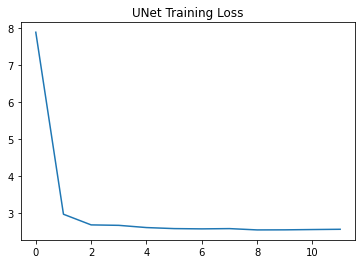

In [11]:
# Training loop
dnn_criterion = nn.CrossEntropyLoss()

if (Train_Unet):
    # Initialize model, loss, and optimizer
    model = UNet().cuda()
    dnn_model = VGG11().cuda()
    dnn_model.load_state_dict(torch.load(DNN_PATH))

    # Freeze the DNN classifier weights
    for param in dnn_model.parameters():
        param.requires_grad = False

    # Hyperparameters
    alpha = 0.5
    beta = 0.3

    step_size = 4
    gamma = 0.5

    # criterion = nn.BCELoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history = []

    # Training loop for U-Net and classifier
    for epoch in range(num_epochs):
        epoch_loss = 0
        print('e:', epoch)
        for i, (images, input_labels) in enumerate(train_loader):
            images = images.cuda()
            input_labels = input_labels.cuda()

            # Generate target labels (different from input labels)
            target_labels = (input_labels + torch.randint(1, 9, size=(input_labels.size(0),)).cuda()) % 10

            # Forward pass
            outputs = model(images, input_labels, target_labels)

            eroded_images = erode_images(images)
            synthetic_target_digits = torch.cat([generate_synthetic_digits(d, 1) for d in target_labels]).cuda()


            # Generate target images (same digit as target labels)
            target_images = images.clone()
            for j in range(input_labels.size(0)):
               target_images[j] = find_nearest_neighbor(images, target_labels, target_labels[j], eroded_images, synthetic_target_digits)

            # Compute reconstruction loss
            reconstruction_loss = criterion(outputs, target_images)

            # Train the classifier on the reconstructed images
            classifier_outputs = dnn_model(outputs)
            classification_loss = dnn_criterion(classifier_outputs, target_labels)
            loss_on_loss = torch.abs(test_loss - classification_loss)
            p_loss = perceptual_loss(dnn_model, images, outputs)

            # Total loss
            total_loss = 10 * reconstruction_loss + alpha * classification_loss + beta * p_loss + loss_on_loss
            epoch_loss += total_loss.item() / input_labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if (i+1) % 50 == 0:
                print('loss:' , total_loss.data.cpu().numpy(), 
                      'recon loss:', 10 * reconstruction_loss.data.cpu().numpy(), 
                      'dnn loss:', alpha * classification_loss.data.cpu().numpy(),
                      'loss on loss:', loss_on_loss.data.cpu().numpy(),
                      'p_loss:', beta * p_loss.data.cpu().numpy())
                
                save_image(outputs.data, './output/%03d/%04d_recon.png' % ( epoch, i))
                save_image(images.data, './output/%03d/%04d_img.png' % ( epoch, i))
                save_image(target_images.data, './output/%03d/%04d_target.png' % ( epoch, i))

                # Convert the images to NumPy arrays
                images_np = images.cpu().numpy()
                target_images_np = target_images.cpu().numpy()
                reconstructed_images_np = outputs.detach().cpu().numpy()

                compare_histograms(images_np, target_images_np, reconstructed_images_np, epoch, i)

        scheduler.step()
        loss_history.append(epoch_loss)


    torch.save(model.state_dict(), UNET_PATH)
    plt.plot(range(0, num_epochs), loss_history)
    plt.title("UNet Training Loss")

# Testing

In [12]:
def generate_augmented_test_images(model, test_loader, num_augmented_images=1000):
    augmented_images = []
    augmented_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()

            target_labels = (labels + torch.randint(1, 9, size=(BATCH_SIZE,)).cuda()) % 10
            outputs = model(images, labels, target_labels)
            
            augmented_images.append(outputs.cpu())
            augmented_labels.append(target_labels.cpu())
            
            if len(augmented_images) * BATCH_SIZE >= num_augmented_images:
                break
    
    augmented_images = torch.cat(augmented_images)[:num_augmented_images]
    augmented_labels = torch.cat(augmented_labels)[:num_augmented_images]
    
    return augmented_images, augmented_labels

augmented_test_images, augmented_test_labels = generate_augmented_test_images(model, test_loader)


In [13]:
resized_train_images = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

train_images = torch.cat([resized_train_images, augmented_test_images])
train_labels = torch.cat([torch.tensor(train_dataset.targets ), augmented_test_labels])

<ipython-input-13-04b10a5f548e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.cat([torch.tensor(train_dataset.targets ), augmented_test_labels])


In [14]:
train_dataset_extended = TensorDataset(train_images, train_labels)
train_loader_extended = DataLoader(train_dataset_extended, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [15]:
dnn_model = VGG11().cuda()  # Define your classifier (e.g., a CNN)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dnn_model.parameters(), lr=1e-5)


# Training loop for the new classifier
acc_history = []
test_acc_history = []
for epoch in range(dnn_epoch):
    total_correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader_extended):
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = dnn_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(outputs, 1)
        correct = pred.eq(labels).cpu().sum().item()
        total_correct += correct
        total += BATCH_SIZE

    if((epoch + 1 )% 10 == 0):
        print("e:", epoch, 'acc:',acc_history[-1], 'test_acc:', test_acc_history[-1])
    acc_history.append(total_correct / total)
    test_acc_history.append(dnn_test(dnn_model, test_loader)[0])

e: 9 acc: 0.9491859243697479 test_acc: 0.9526241987179487
e: 19 acc: 0.9780396533613446 test_acc: 0.9770633012820513
e: 29 acc: 0.9862788865546218 test_acc: 0.9838741987179487
e: 39 acc: 0.9909237132352942 test_acc: 0.9887820512820513
e: 49 acc: 0.9937303046218487 test_acc: 0.9879807692307693


(0.0, 1.0)

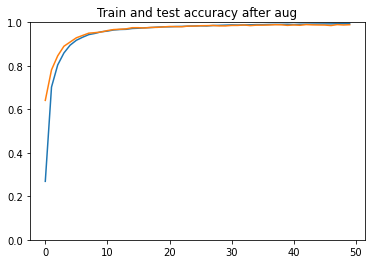

In [16]:
plt.plot(range(0, dnn_epoch), acc_history)
plt.plot(range(0, dnn_epoch), test_acc_history)
plt.title('Train and test accuracy after aug')
plt.ylim(0, 1)

# Unet Recon img

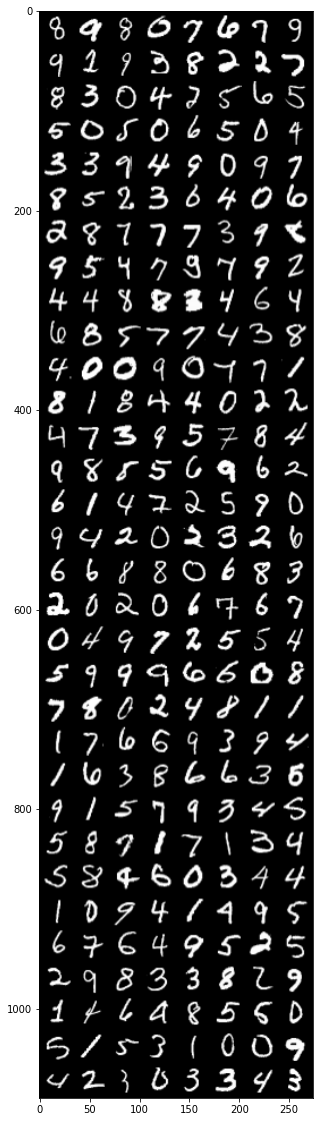

In [17]:
image = plt.imread('./output/%03d/0199_img.png'% (num_epochs -1))
plt.figure(figsize = (20,20))
plt.imshow(image)

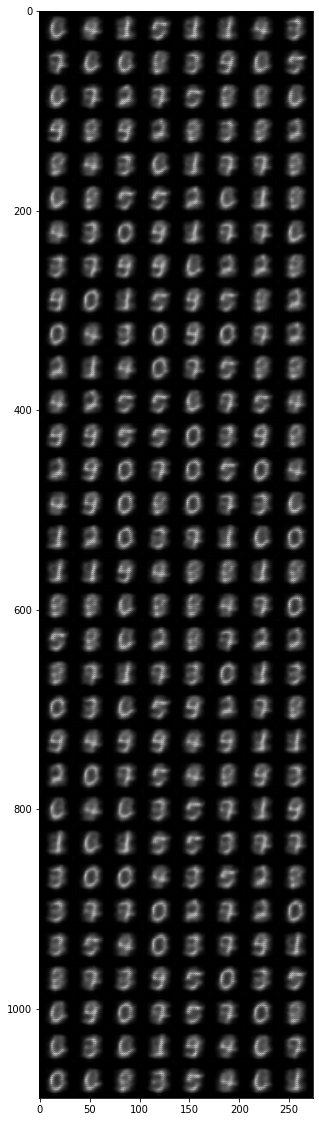

In [18]:
image = plt.imread('./output/%03d/0199_recon.png'% (num_epochs -1))
plt.figure(figsize = (20,20))
plt.imshow(image)

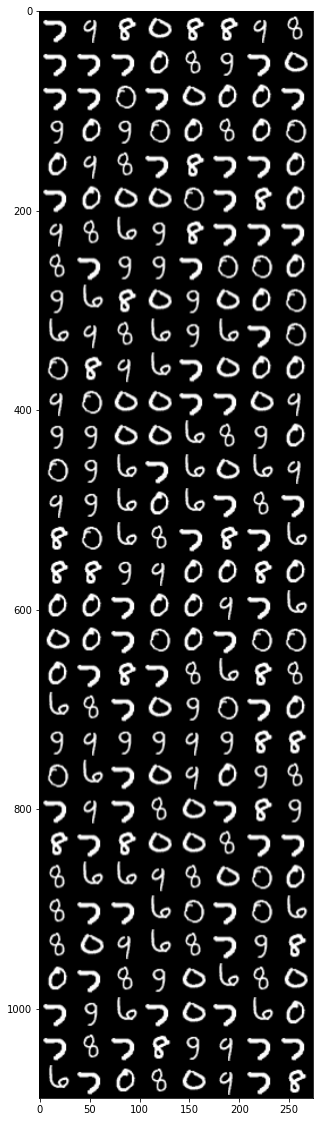

In [19]:
image = plt.imread('./output/%03d/0199_target.png'% (num_epochs -1))
plt.figure(figsize = (20,20))
plt.imshow(image)

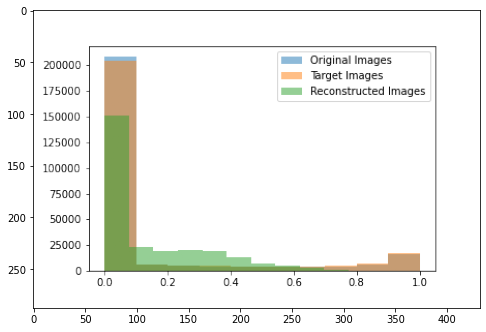

In [20]:
image = plt.imread('./output/%03d/0199_dist.png'% (num_epochs -1))
plt.figure(figsize = (8,8))
plt.imshow(image)